# CNN Histopath
Data from https://www.kaggle.com/competitions/histopathologic-cancer-detection/data?select=train

Classifying large numbers of small pathology images.

## Data Import and Exploration


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [10]:
!ls data

sample_submission.csv  test  train  train_labels.csv


In [11]:
train_labels = pd.read_csv("data/train_labels.csv")

In [12]:
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


In [13]:
train_labels.head

<bound method NDFrame.head of                                               id  label
0       f38a6374c348f90b587e046aac6079959adf3835      0
1       c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2       755db6279dae599ebb4d39a9123cce439965282d      0
3       bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4       068aba587a4950175d04c680d38943fd488d6a9d      0
...                                          ...    ...
220020  53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6      0
220021  d4b854fe38b07fe2831ad73892b3cec877689576      1
220022  3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75      0
220023  f129691c13433f66e1e0671ff1fe80944816f5a2      0
220024  a81f84895ddcd522302ddf34be02eb1b3e5af1cb      1

[220025 rows x 2 columns]>

[130908, 89117]


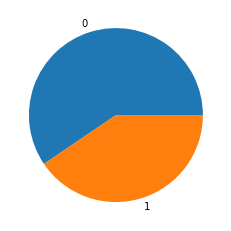

In [14]:
label_dist = [len(train_labels[train_labels['label']==0]), len(train_labels[train_labels['label']==1])]
label_dist_id = [0,1]
plt.pie(label_dist,labels=label_dist_id)
print(label_dist)

So more 0 than 1, but ~about~ even. Looks reasonable.

### What about these images?

In [15]:
!ls data/train | head

00001b2b5609af42ab0ab276dd4cd41c3e7745b5.tif
000020de2aa6193f4c160e398a8edea95b1da598.tif
00004aab08381d25d315384d646f5ce413ea24b1.tif
0000d563d5cfafc4e68acb7c9829258a298d9b6a.tif
0000da768d06b879e5754c43e2298ce48726f722.tif
0000f8a4da4c286eee5cf1b0d2ab82f979989f7b.tif
00010f78ea8f878117500c445a658e5857f4e304.tif
00011545a495817817c6943583b294c900a137b8.tif
000126ec42770c7568204e2f6e07eb9a07d5e121.tif
00014e39b5df5f80df56f18a0a049d1cc6de430a.tif
ls: write error: Broken pipe


In [16]:
from PIL import Image

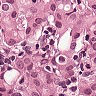

(96, 96, 3)


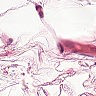

In [17]:
sample_img = Image.open("data/train/00001b2b5609af42ab0ab276dd4cd41c3e7745b5.tif")
display(sample_img)
sample_img_np = np.array(sample_img)
print(sample_img_np.shape)
# the above is a 0, what does 1 look like?
sample_img_pos = Image.open("data/train/000020de2aa6193f4c160e398a8edea95b1da598.tif")
display(sample_img_pos)

In [18]:
## Are they all the same size?
shapes_x = []
shapes_y = []
shapes_z = []
for x in train_labels['id']:
    with Image.open("data/train/" + x + ".tif") as i:
        a,b,c = np.array(i).shape
        shapes_x.append(a)
        shapes_y.append(b)
        shapes_z.append(c)


In [19]:
print ("x:", min(shapes_x), "to", max(shapes_x))
print ("y:", min(shapes_y), "to", max(shapes_y))
print ("z:", min(shapes_z), "to", max(shapes_z))


x: 96 to 96
y: 96 to 96
z: 3 to 3


In [20]:
len(shapes_z)

220025

### Preparing for the model.
We need our own labeled test/train split.


In [1]:
from keras_preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator()

train_image_generator = train_datagen.flow_from_directory(
    "./data/train",
    class_mode="binary",
    batch_size=16,
    color_mode="rgb",
    target_size=(96, 96),
    class_mode=None,
    seed=420,
    shuffle=True,
)

test_image_generator = train_datagen.flow_from_directory(
    "./data/train",
    class_mode="binary",
    batch_size=16,
    color_mode="rgb",
    target_size=(96, 96),
    class_mode=None,
    seed=420,
    shuffle=True,
)


Found 0 images belonging to 6 classes.
Found 0 images belonging to 6 classes.


Only run this once
```python
# actually I think we need to do a file format conversion.
! mkdir -p data/train/converted/false
! mkdir -p data/train/converted/true

for x in train_labels.itertuples(index=False, name=None):
    identifier, label = x
    if label == 0:
        d = "data/train/converted/false/"
    else:
        d = "data/train/converted/true/"
    with Image.open("data/train/" + identifier + ".tif") as i:
        i.save(d + identifier + ".png")
```        

In [41]:
import tensorflow as tf

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "./data/train/converted",
    labels='inferred', 
    validation_split=0.2, 
    seed=42060, 
    image_size=(96, 96),
    batch_size=32,
    subset="training")
validation = tf.keras.preprocessing.image_dataset_from_directory(
    "./data/train/converted",
    labels='inferred', 
    validation_split=0.2, 
    seed=42060, 
    image_size=(96, 96),
    batch_size=32,
    subset="validation")

Found 220025 files belonging to 2 classes.
Using 176020 files for training.
Found 220025 files belonging to 2 classes.
Using 44005 files for validation.


# The Model
The images are all the same size and small. Let's use a CNN.
The description of the dataset says that a positive label means that the center has "at least one positive pixel at the center", so I'll take that into account.

In [36]:
import tensorflow as tf

from tensorflow.keras import layers, models

In [45]:
model = models.Sequential()
model.add(layers.Conv2D(96, (3, 3), activation='relu', input_shape=(96, 96, 3)))
model.add(layers.MaxPooling2D((5, 5)))
model.add(layers.Conv2D(5*96, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(5*96, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(5*96, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 94, 94, 96)        2688      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 18, 18, 96)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 480)       415200    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 8, 8, 480)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 6, 6, 480)         2074080   
_________________________________________________________________
flatten_3 (Flatten)          (None, 17280)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 480)              

In [48]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [50]:
history = model.fit(
  dataset,
  validation_data=validation,
  epochs=1
)

5501/5501 [==============================] - 2977s 541ms/step - loss: 0.6835 - accuracy: 0.5951 - val_loss: 0.6754 - val_accuracy: 0.5941


In [ ]:
plt.plot(history.history['accuracy'])

# Labeling Test Data

Only run the test to png conversion once.
```python
! mkdir -p ./data/test/converted/
import os
files = os.listdir('./data/test/')
ids = [x.split(".")[0] for x in files]

for x in ids:
    d = "./data/test/converted/"
    with Image.open("data/test/", + x + '.tif') as i:
        i.save(d + x + ".png")
```

In [110]:
import os
results = []
files = os.listdir('./data/test/')
ids = [x.split(".")[0] for x in files if len(x.split("."))>1]

print(len(ids))


57458


In [ ]:
threshold = 0.5
raw_preds = []

for iden in ids:
    with Image.open("data/test/converted/" + iden + '.png') as img:
        j = np.array(img)
        res = model.predict(np.expand_dims(j, axis=0))
        raw_pred = res[0][0]
        raw_preds.append(raw_pred)
        prediction = int(raw_pred > threshold)
        results.append({"id":iden, "label": prediction})
        if len(results) % 10000 ==0:
            print(len(results))

10000
20000


In [ ]:
plt.hist(raw_preds)

In [ ]:
results

submission = pd.DataFrame.from_records(results)
submission.to_csv("submission.csv", index=False)

# Conclusions
My computer is very slow, and the dataset is large. I certainly undertrained the data and used an oversimplified model. In the future, I'd want to let this run more.
Also worth noting that the model result is expecially bad, the accuracy is about the same as "always predict 0"